### Librerias

In [1]:
from transformers import BertModel,AutoTokenizer, AutoModelForSequenceClassification,BertTokenizer,AdamW, get_linear_schedule_with_warmup, RobertaTokenizer,AutoTokenizer,AlbertTokenizerFast,AlbertModel, RobertaModel, RobertaTokenizer
from textwrap import wrap
import torch.nn.functional as F
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader
from torch import nn,optim
import numpy as np
import torch
from nltk.tokenize.treebank import TreebankWordDetokenizer
import nltk
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score,f1_score,precision_score,mean_squared_error,roc_curve, roc_auc_score, r2_score,mean_absolute_error

c:\Users\Miguel\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Cargar Tokenaizer

In [2]:
tokenizer = AutoTokenizer.from_pretrained("../Tokenizer_Train/Bert_Hotel_len_data/")

In [65]:
model = AutoModelForSequenceClassification.from_pretrained("../Logic/Fine_turned/")

### Cargar Modelo

In [3]:
class ModelSentiment(nn.Module):

    def __init__(self, n_classes):
        super(ModelSentiment, self).__init__()
        

    def forward(self, input_ids, attention_mask):
        cls_output = self.model(input_ids, attention_mask)
        drop_output = self.drop(cls_output.pooler_output)
        output = self.linear(drop_output)
        return output
        


In [4]:
with open("../Model_Train/model.pkl", "rb") as file:
    model = pickle.load(file)

In [149]:
model

ModelSentiment(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

### Funcion Prediccion

In [5]:
def classifySentiment(review_text):
    encoding_review = tokenizer.encode_plus(
        review_text,
        add_special_tokens = True,
        max_length = 250,
        padding = "max_length",
        return_token_type_ids = False,
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )

    input_ids = encoding_review['input_ids']
    attention_mask = encoding_review['attention_mask']
    output = model(input_ids,attention_mask)

    _, prediction = torch.max(output,dim=1)
    probs = F.softmax(output, dim=1)
    print(probs)
    
    if probs[0,1].item() > 0.992:
        return 1
    elif probs[0,0].item() > 0.992:
        return 0
    else:
        return 2

In [11]:
classifySentiment("la habitación era buena")

tensor([[0.0018, 0.9982]], grad_fn=<SoftmaxBackward0>)


1

### Cargar Datos

In [18]:
df = pd.read_csv('../Data/hotel_review_test_5000.csv', sep=';')
df = df[:2550]
df = df[2450:]
df_positivos = df[df['sentiment']==1]
df_negativos = df[df['sentiment']==0]

textos_pos = df_positivos['review']
textos_neg = df_negativos['review']

labels_true = df['sentiment']
textos = list(df['review'])
df['sentiment'].value_counts()

sentiment
1    50
0    50
Name: count, dtype: int64

In [19]:
opiniones_pos = []
opiniones_neg = []
for sent in textos_pos:
    opiniones_pos.append(sent) 
for sent in textos_neg:
    opiniones_neg.append(sent) 

In [20]:
labels_pred = []
for texto in tqdm(textos):
    labels_pred.append(classifySentiment(texto))

100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


In [21]:
data = {'review':textos,'label_true':labels_true,'label_pred':labels_pred}
dataset = pd.DataFrame(data)
#Despues de guardar el archivo volver a cargar para resfrescar el indice
dataset.reset_index().to_excel('Result_test_hotel_5000.xlsx',index=False)

### Metricas

In [22]:
accuracy = accuracy_score(labels_true, labels_pred)
precision = precision_score(labels_true, labels_pred)
recall = recall_score(labels_true, labels_pred)
f1 = f1_score(labels_true, labels_pred)
error = mean_squared_error(labels_true, labels_pred)           #Problemas de Regresion
absolute_error = mean_absolute_error(labels_true,labels_pred)  #Problemas de Regresion
areaBC = roc_auc_score(labels_true,labels_pred)
r2 = r2_score(labels_true,labels_pred)

In [23]:
print("accuracy:" , accuracy)
print("precision:" , precision)
print("recall:" , recall)
print("f1:" , f1)
print("mean_squared_error:", error)
print("absolute_error:", absolute_error)
print("area_bajo_curva:", areaBC)
print("r_squared:", r2)

accuracy: 0.52
precision: 0.5102040816326531
recall: 1.0
f1: 0.6756756756756758
mean_squared_error: 0.48
absolute_error: 0.48
area_bajo_curva: 0.52
r_squared: -0.9199999999999999


Resultados del modelo de hoteles vs opiniones de tripAdvisor

#### Matriz de Confusion

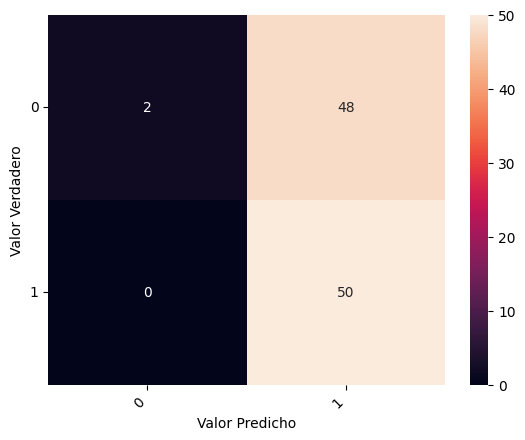

In [24]:
df_cm = confusion_matrix(labels_true, labels_pred,labels=[0,1])
heatmap = sns.heatmap(df_cm,annot=True,fmt="d")
heatmap.yaxis.set_ticklabels([0,1],rotation=0,ha='right')
heatmap.xaxis.set_ticklabels([0,1],rotation=45,ha='right')
plt.ylabel('Valor Verdadero')
plt.xlabel('Valor Predicho');

Resultados del modelo de hoteles vs opiniones de tripAdvisor

#### Curva ROC

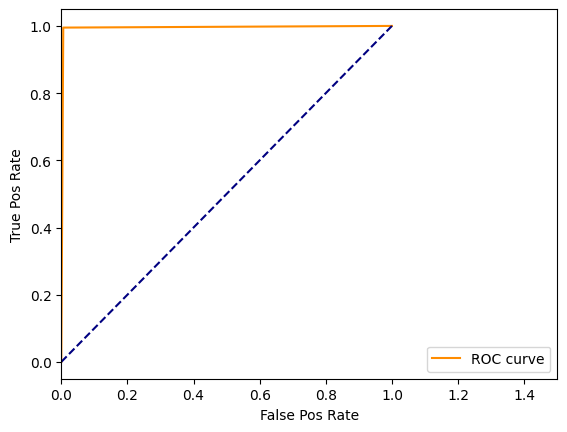

In [12]:
fpr, tpr, thresholds = roc_curve(labels_true,labels_pred)
plt.figure()
plt.plot(fpr,tpr,color='darkorange',label='ROC curve')
plt.plot([0,1],[0,1],color='navy',linestyle='--')
plt.xlim([0.0,1.0])
plt.xlim([0.0,1.5])
plt.xlabel('False Pos Rate')
plt.ylabel('True Pos Rate')
plt.legend(loc='lower right')
plt.show()


### Graficos

In [ ]:
fig = plt.figure(figsize=[9,5])

names = ['Positivas', 'Negativas']
values = [labels_true.count(1),labels_true.count(0)]
values_2 = [labels_pred.count(1),labels_pred.count(0)]

ax = fig.add_subplot(121)
ax.bar(names, values,color='c')
ax.set_title("Etiquetas Reales")
for i in range(len(names)):
    plt.text(names[i],values[i]+1,str(values[i]),ha='center')

ax_2 = fig.add_subplot(122)
ax_2.bar(names, values_2, color='palegreen')
ax_2.set_title("Etiquetas Predichas")
for i in range(len(names)):
    plt.text(names[i],values_2[i]+1,str(values_2[i]),ha='center')

plt.suptitle("Cantidad de Etiquetas ")
plt.show()

### Nube de palabras

In [15]:
sw = set(stop_words.get_stop_words('es'))
sw.add(',')
sw.add('2')
sw.add('3')

cleanPos = []
for sent in textos_pos:
    for word in sent.lower().split():
        if not word in sw:
            cleanPos.append(word)

cleanNeg = []
for sent in textos_neg:
    for word in sent.lower().split():
        if not word in sw:
            cleanNeg.append(word)


In [16]:
freq_dist_pos = nltk.FreqDist(cleanPos).most_common(20)
freq_dist_neg = nltk.FreqDist(cleanNeg).most_common(20)
terminos_relevantes = freq_dist_pos + freq_dist_neg
terminos_pos = [tupla[0] for tupla in freq_dist_pos]
terminos_neg = [tupla[0] for tupla in freq_dist_neg]

In [17]:
def color_func(word, font_size, position, orientation, random_state,**kwargs):
    if word in terminos_pos and word not in terminos_neg:
        return "green"
    elif word in terminos_neg and word not in terminos_pos:
        return "red"
    else:
        return "black"

In [18]:
wordcloud = WordCloud(width=800,height=400, background_color="white", color_func=color_func).generate_from_frequencies(dict(terminos_relevantes))

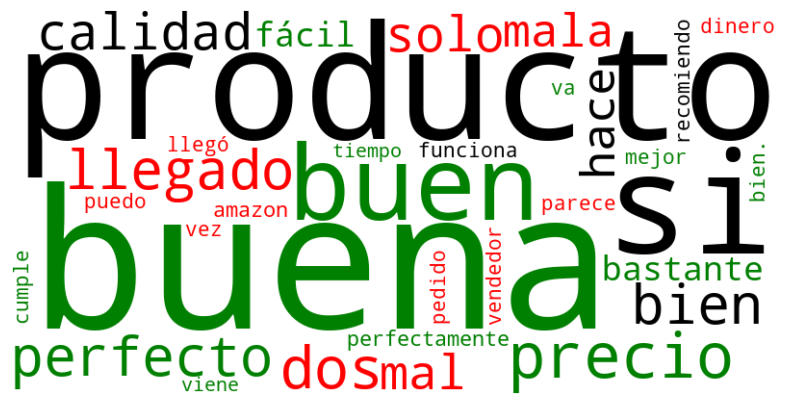

In [19]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()